# Description

(Please, take a look at the README.md file in this directory for instructions on how to run this notebook)

This notebook reads all gene correlations across all chromosomes and computes a single correlation matrix by assembling a big correlation matrix with all genes.

# Modules

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy.spatial.distance import squareform
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import conf
from entity import Gene

# Settings

In [3]:
# reference panel
REFERENCE_PANEL = "GTEX_V8"
# REFERENCE_PANEL = "1000G"

# prediction models
## mashr
EQTL_MODEL = "MASHR"
EQTL_MODEL_FILES_PREFIX = "mashr_"

# ## elastic net
# EQTL_MODEL = "ELASTIC_NET"
# EQTL_MODEL_FILES_PREFIX = "en_"

# make it read the prefix from conf.py
EQTL_MODEL_FILES_PREFIX = None

In [4]:
if EQTL_MODEL_FILES_PREFIX is None:
    EQTL_MODEL_FILES_PREFIX = conf.PHENOMEXCAN["PREDICTION_MODELS"][
        f"{EQTL_MODEL}_PREFIX"
    ]

In [5]:
display(f"Using eQTL model: {EQTL_MODEL} / {EQTL_MODEL_FILES_PREFIX}")

'Using eQTL model: MASHR / mashr_'

In [6]:
REFERENCE_PANEL_DIR = conf.PHENOMEXCAN["LD_BLOCKS"][f"{REFERENCE_PANEL}_GENOTYPE_DIR"]

In [7]:
display(f"Using reference panel folder: {str(REFERENCE_PANEL_DIR)}")

'Using reference panel folder: /opt/data/data/phenomexcan/ld_blocks/reference_panel_gtex_v8'

In [8]:
OUTPUT_DIR_BASE = (
    conf.PHENOMEXCAN["LD_BLOCKS"][f"GENE_CORRS_DIR"]
    / REFERENCE_PANEL.lower()
    / EQTL_MODEL.lower()
)
display(OUTPUT_DIR_BASE)
OUTPUT_DIR_BASE.mkdir(parents=True, exist_ok=True)

PosixPath('/opt/data/data/phenomexcan/ld_blocks/gene_corrs/gtex_v8/mashr')

In [9]:
display(f"Using output dir base: {OUTPUT_DIR_BASE}")

'Using output dir base: /opt/data/data/phenomexcan/ld_blocks/gene_corrs/gtex_v8/mashr'

In [10]:
INPUT_DIR = OUTPUT_DIR_BASE / "by_chr" / "corrected_positive_definite"
display(INPUT_DIR)
assert INPUT_DIR.exists()

PosixPath('/opt/data/data/phenomexcan/ld_blocks/gene_corrs/gtex_v8/mashr/by_chr/corrected_positive_definite')

# Load data

## Gene correlations

In [11]:
all_gene_corr_files = list(INPUT_DIR.glob("gene_corrs-chr*.pkl"))

In [12]:
# sort by chromosome
all_gene_corr_files = sorted(
    all_gene_corr_files, key=lambda x: int(x.name.split("-chr")[1].split(".pkl")[0])
)

In [13]:
len(all_gene_corr_files)

22

In [14]:
all_gene_corr_files

[PosixPath('/opt/data/data/phenomexcan/ld_blocks/gene_corrs/gtex_v8/mashr/by_chr/corrected_positive_definite/gene_corrs-chr1.pkl'),
 PosixPath('/opt/data/data/phenomexcan/ld_blocks/gene_corrs/gtex_v8/mashr/by_chr/corrected_positive_definite/gene_corrs-chr2.pkl'),
 PosixPath('/opt/data/data/phenomexcan/ld_blocks/gene_corrs/gtex_v8/mashr/by_chr/corrected_positive_definite/gene_corrs-chr3.pkl'),
 PosixPath('/opt/data/data/phenomexcan/ld_blocks/gene_corrs/gtex_v8/mashr/by_chr/corrected_positive_definite/gene_corrs-chr4.pkl'),
 PosixPath('/opt/data/data/phenomexcan/ld_blocks/gene_corrs/gtex_v8/mashr/by_chr/corrected_positive_definite/gene_corrs-chr5.pkl'),
 PosixPath('/opt/data/data/phenomexcan/ld_blocks/gene_corrs/gtex_v8/mashr/by_chr/corrected_positive_definite/gene_corrs-chr6.pkl'),
 PosixPath('/opt/data/data/phenomexcan/ld_blocks/gene_corrs/gtex_v8/mashr/by_chr/corrected_positive_definite/gene_corrs-chr7.pkl'),
 PosixPath('/opt/data/data/phenomexcan/ld_blocks/gene_corrs/gtex_v8/mashr/by

In [15]:
assert len(all_gene_corr_files) == 22

## MultiPLIER Z

In [16]:
multiplier_z_genes = pd.read_pickle(
    conf.MULTIPLIER["MODEL_Z_MATRIX_FILE"]
).index.tolist()

In [17]:
len(multiplier_z_genes)

6750

In [18]:
multiplier_z_genes[:10]

['GAS6',
 'MMP14',
 'DSP',
 'MARCKSL1',
 'SPARC',
 'CTSD',
 'EPAS1',
 'PALLD',
 'PHC2',
 'LGALS3BP']

## Get gene objects

In [19]:
multiplier_gene_obj = {
    gene_name: Gene(name=gene_name)
    for gene_name in multiplier_z_genes
    if gene_name in Gene.GENE_NAME_TO_ID_MAP
}

In [20]:
len(multiplier_gene_obj)

6454

In [21]:
multiplier_gene_obj["GAS6"].ensembl_id

'ENSG00000183087'

In [22]:
_gene_obj = list(multiplier_gene_obj.values())

genes_info = pd.DataFrame(
    {
        "name": [g.name for g in _gene_obj],
        "id": [g.ensembl_id for g in _gene_obj],
        "chr": [g.chromosome for g in _gene_obj],
        "start_position": [g.get_attribute("start_position") for g in _gene_obj],
    }
).dropna()

In [23]:
assert not genes_info.isna().any().any()

In [24]:
genes_info.dtypes

name               object
id                 object
chr                object
start_position    float64
dtype: object

In [25]:
genes_info["chr"] = genes_info["chr"].apply(pd.to_numeric, downcast="integer")
genes_info["start_position"] = genes_info["start_position"].astype(
    int
)  # .apply(pd.to_numeric, downcast="signed")

In [26]:
genes_info.dtypes

name              object
id                object
chr                int64
start_position     int64
dtype: object

In [27]:
genes_info.shape

(6452, 4)

In [28]:
genes_info.head()

,name,id,chr,start_position
0,GAS6,ENSG00000183087,13,113820549
1,MMP14,ENSG00000157227,14,22836560
2,DSP,ENSG00000096696,6,7541617
3,MARCKSL1,ENSG00000175130,1,32333839
4,SPARC,ENSG00000113140,5,151661096


In [29]:
assert not genes_info.isna().any().any()

# Create full correlation matrix

In [30]:
genes_info = genes_info.sort_values(["chr", "start_position"])

In [31]:
genes_info

,name,id,chr,start_position
3430,NOC2L,ENSG00000188976,1,944203
798,HES4,ENSG00000188290,1,998962
208,ISG15,ENSG00000187608,1,1001138
4937,AGRN,ENSG00000188157,1,1020120
2871,TNFRSF18,ENSG00000186891,1,1203508
...,...,...,...,...
4685,CPT1B,ENSG00000205560,22,50568861
4540,CHKB,ENSG00000100288,22,50578949
4182,MAPK8IP2,ENSG00000008735,22,50600793
3698,ARSA,ENSG00000100299,22,50622754


In [32]:
full_corr_matrix = pd.DataFrame(
    np.zeros((genes_info.shape[0], genes_info.shape[0])),
    index=genes_info["id"].tolist(),
    columns=genes_info["id"].tolist(),
)

In [33]:
assert full_corr_matrix.index.is_unique & full_corr_matrix.columns.is_unique

In [34]:
for chr_corr_file in all_gene_corr_files:
    print(chr_corr_file.name, flush=True)

    corr_data = pd.read_pickle(chr_corr_file)
    full_corr_matrix.loc[corr_data.index, corr_data.columns] = corr_data

gene_corrs-chr1.pkl
gene_corrs-chr2.pkl
gene_corrs-chr3.pkl
gene_corrs-chr4.pkl
gene_corrs-chr5.pkl
gene_corrs-chr6.pkl
gene_corrs-chr7.pkl
gene_corrs-chr8.pkl
gene_corrs-chr9.pkl
gene_corrs-chr10.pkl
gene_corrs-chr11.pkl
gene_corrs-chr12.pkl
gene_corrs-chr13.pkl
gene_corrs-chr14.pkl
gene_corrs-chr15.pkl
gene_corrs-chr16.pkl
gene_corrs-chr17.pkl
gene_corrs-chr18.pkl
gene_corrs-chr19.pkl
gene_corrs-chr20.pkl
gene_corrs-chr21.pkl
gene_corrs-chr22.pkl


In [35]:
full_corr_matrix.shape

(6452, 6452)

In [36]:
full_corr_matrix

,ENSG00000188976,ENSG00000188290,ENSG00000187608,ENSG00000188157,ENSG00000186891,ENSG00000186827,ENSG00000176022,ENSG00000160087,ENSG00000131584,ENSG00000169962,...,ENSG00000196576,ENSG00000128165,ENSG00000100253,ENSG00000130489,ENSG00000025708,ENSG00000205560,ENSG00000100288,ENSG00000008735,ENSG00000100299,ENSG00000251322
ENSG00000188976,1.000000,0.062866,-0.010847,-0.131670,0.037099,0.019131,-0.001807,-0.056218,0.026165,-0.000353,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000188290,0.062866,1.000000,0.089331,-0.033630,0.037086,0.006598,-0.003540,-0.028828,0.057050,-0.035404,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000187608,-0.010847,0.089331,1.000000,0.001009,-0.035575,-0.022576,-0.084673,-0.045836,-0.022564,-0.025865,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000188157,-0.131670,-0.033630,0.001009,1.000000,-0.084165,-0.081193,-0.123105,-0.013481,-0.004322,0.009895,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000186891,0.037099,0.037086,-0.035575,-0.084165,1.000000,0.061212,0.175985,-0.064790,0.155956,-0.031170,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000205560,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.039704,-0.048328,-0.037059,-0.087386,0.162101,1.000000,0.225112,0.021292,0.034473,-0.060927
ENSG00000100288,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.047043,-0.021478,0.039950,-0.201905,0.204438,0.225112,1.000000,-0.049255,0.094441,-0.086780
ENSG00000008735,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.042973,0.049793,-0.005677,0.071305,-0.041385,0.021292,-0.049255,1.000000,-0.058584,-0.044446
ENSG00000100299,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.041372,-0.034301,0.014840,-0.169171,0.102987,0.034473,0.094441,-0.058584,1.000000,0.021316


## Some checks

In [37]:
full_corr_matrix[full_corr_matrix > 1.0] = 1.0
np.fill_diagonal(full_corr_matrix.values, 1.0)

In [38]:
assert np.all(full_corr_matrix.to_numpy().diagonal() == 1.0)

In [39]:
# check that all genes have a value
assert not full_corr_matrix.isna().any().any()

In [40]:
_min_val = full_corr_matrix.min().min()
display(_min_val)
assert _min_val >= -1.0

-0.5418240489351449

In [41]:
_max_val = full_corr_matrix.max().max()  # this only captures the ones in the diagonal
display(_max_val)
assert _max_val <= 1.0

1.0

In [42]:
# check that matrix is positive definite
eigs = np.linalg.eigvals(full_corr_matrix.to_numpy())
assert np.all(eigs > 0)

In [43]:
# this should not fail
np.linalg.cholesky(np.linalg.inv(full_corr_matrix))

array([[ 1.04043366,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.03080347,  1.02274365,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.0173705 , -0.07730791,  1.02046879, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  1.00266005,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.05781607,
         1.00022727,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.04333218,
        -0.02132132,  1.        ]])

In [44]:
# full_corr_matrix = full_corr_matrix.astype(np.float32)

# Try to fit GLS and see if it works (with random data)

In [45]:
import statsmodels.api as sm

In [46]:
y = np.random.rand(full_corr_matrix.shape[0])

In [47]:
X = np.random.rand(full_corr_matrix.shape[0], 2)
X[:, 0] = 1

In [48]:
# this should not throw an exception: LinAlgError("Matrix is not positive definite")
# _gls_model = sm.GLS(y, X, sigma=np.identity(y.shape[0]))
_gls_model = sm.GLS(y, X, sigma=full_corr_matrix)

In [49]:
_gls_results = _gls_model.fit()

In [50]:
print(_gls_results.summary())

                            GLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            GLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7422
Date:                Sat, 18 Jun 2022   Prob (F-statistic):              0.389
Time:                        12:13:58   Log-Likelihood:                -1256.2
No. Observations:                6452   AIC:                             2516.
Df Residuals:                    6450   BIC:                             2530.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5092      0.007     70.885      0.0

## Stats

In [51]:
full_corr_matrix_flat = full_corr_matrix.mask(
    np.triu(np.ones(full_corr_matrix.shape)).astype(bool)
).stack()

In [52]:
display(full_corr_matrix_flat.shape)
assert full_corr_matrix_flat.shape[0] == int(
    full_corr_matrix.shape[0] * (full_corr_matrix.shape[0] - 1) / 2
)

(20810926,)

In [53]:
full_corr_matrix_flat[full_corr_matrix_flat == 1.0]

Series([], dtype: float64)

In [54]:
full_corr_matrix_flat.head()

ENSG00000188290  ENSG00000188976    0.062866
ENSG00000187608  ENSG00000188976   -0.010847
                 ENSG00000188290    0.089331
ENSG00000188157  ENSG00000188976   -0.131670
                 ENSG00000188290   -0.033630
dtype: float64

In [55]:
full_corr_matrix_flat.describe().apply(str)

count                20810926.0
mean     3.5499220846189066e-07
std       0.0050789170486224035
min         -0.5418240489351449
25%                         0.0
50%                         0.0
75%                         0.0
max          0.5198900384631986
dtype: object

In [56]:
full_corr_matrix_flat_quantiles = full_corr_matrix_flat.quantile(np.arange(0, 1, 0.05))
display(full_corr_matrix_flat_quantiles)

0.00   -0.541824
0.05    0.000000
0.10    0.000000
0.15    0.000000
0.20    0.000000
0.25    0.000000
0.30    0.000000
0.35    0.000000
0.40    0.000000
0.45    0.000000
0.50    0.000000
0.55    0.000000
0.60    0.000000
0.65    0.000000
0.70    0.000000
0.75    0.000000
0.80    0.000000
0.85    0.000000
0.90    0.000000
0.95    0.000000
dtype: float64

## Plot: distribution

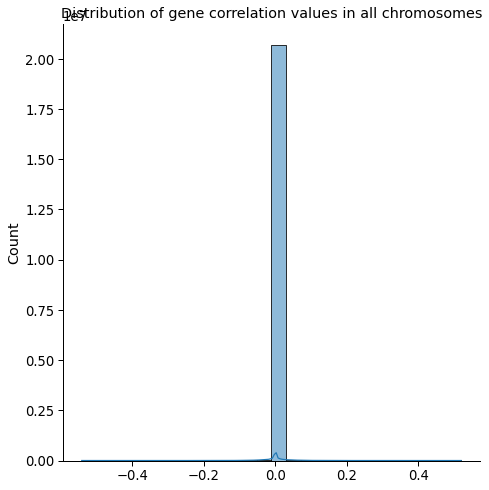

In [57]:
with sns.plotting_context("paper", font_scale=1.5):
    g = sns.displot(full_corr_matrix_flat, kde=True, height=7)
    g.ax.set_title("Distribution of gene correlation values in all chromosomes")

## Plot: heatmap

In [58]:
vmin_val = min(-0.05, full_corr_matrix_flat_quantiles[0.10])
vmax_val = max(0.05, full_corr_matrix_flat_quantiles[0.90])
display(f"{vmin_val} / {vmax_val}")

'-0.05 / 0.05'

Text(0.5, 1.0, 'Gene correlations in all chromosomes')

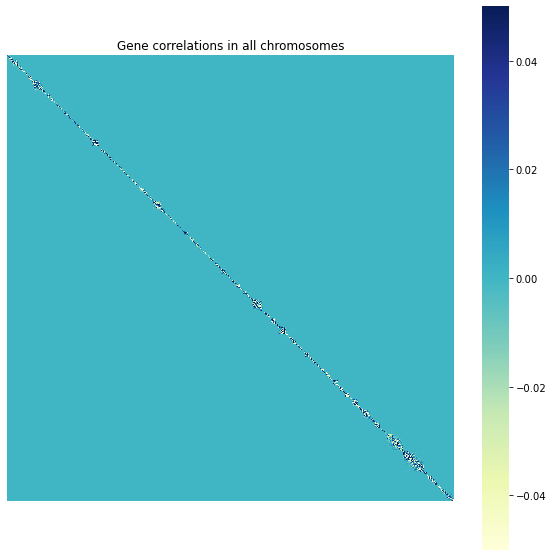

In [59]:
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(
    full_corr_matrix,
    xticklabels=False,
    yticklabels=False,
    square=True,
    vmin=vmin_val,
    vmax=vmax_val,
    cmap="YlGnBu",
    ax=ax,
)
ax.set_title("Gene correlations in all chromosomes")

# Save

## With ensemble ids

In [60]:
output_file_name_template = conf.PHENOMEXCAN["LD_BLOCKS"][
    "GENE_CORRS_FILE_NAME_TEMPLATES"
]["GENE_CORR_AVG"]

output_file = OUTPUT_DIR_BASE / output_file_name_template.format(
    prefix="",
    suffix=f"-ssm_corrs-gene_ensembl_ids",
)
display(output_file)

PosixPath('/opt/data/data/phenomexcan/ld_blocks/gene_corrs/gtex_v8/mashr/multiplier_genes-pred_expression_corr-ssm_corrs-gene_ensembl_ids.pkl')

In [63]:
full_corr_matrix.to_pickle(output_file)

## With gene symbols

In [64]:
output_file_name_template = conf.PHENOMEXCAN["LD_BLOCKS"][
    "GENE_CORRS_FILE_NAME_TEMPLATES"
]["GENE_CORR_AVG"]

output_file = OUTPUT_DIR_BASE / output_file_name_template.format(
    prefix="",
    suffix=f"-ssm_corrs-gene_symbols",
)
display(output_file)

PosixPath('/opt/data/data/phenomexcan/ld_blocks/gene_corrs/gtex_v8/mashr/multiplier_genes-pred_expression_corr-ssm_corrs-gene_symbols.pkl')

In [65]:
full_corr_matrix_gene_symbols = full_corr_matrix.rename(
    index=Gene.GENE_ID_TO_NAME_MAP, columns=Gene.GENE_ID_TO_NAME_MAP
)

In [71]:
assert full_corr_matrix_gene_symbols.index.is_unique

In [72]:
assert full_corr_matrix_gene_symbols.columns.is_unique

In [73]:
full_corr_matrix_gene_symbols.shape

(6452, 6452)

In [74]:
full_corr_matrix_gene_symbols.head()

,NOC2L,HES4,ISG15,AGRN,TNFRSF18,TNFRSF4,B3GALT6,UBE2J2,ACAP3,TAS1R3,...,PLXNB2,ADM2,MIOX,SCO2,TYMP,CPT1B,CHKB,MAPK8IP2,ARSA,SHANK3
NOC2L,1.000000,0.062866,-0.010847,-0.131670,0.037099,0.019131,-0.001807,-0.056218,0.026165,-0.000353,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HES4,0.062866,1.000000,0.089331,-0.033630,0.037086,0.006598,-0.003540,-0.028828,0.057050,-0.035404,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ISG15,-0.010847,0.089331,1.000000,0.001009,-0.035575,-0.022576,-0.084673,-0.045836,-0.022564,-0.025865,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AGRN,-0.131670,-0.033630,0.001009,1.000000,-0.084165,-0.081193,-0.123105,-0.013481,-0.004322,0.009895,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TNFRSF18,0.037099,0.037086,-0.035575,-0.084165,1.000000,0.061212,0.175985,-0.064790,0.155956,-0.031170,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
full_corr_matrix_gene_symbols.to_pickle(output_file)